<b> Exploratory data analysis 2 </b>

Having looked at some correlations and saw that regression strategy isn't working out, let's look at trying to classify the games into different sentiment classes (negative, mixed, positive).

In [316]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime, timedelta

now = datetime(year=2019, month=5, day=26).timestamp()

# note: mean_time is in days
cont_vars = ['num_pre','num_post','mean_time', 'release_date','len_description', 'num_movies',
                 'num_images','score','num_reviews','sentiment']
cat_vars = ['is_action', 'is_adventure', 'is_casual', 'is_mmo', 'is_racing', 'is_rpg', 'is_strategy', 'is_simulation', 'is_sports']

data = pd.read_csv('../data/features_vec_all.csv', usecols=cont_vars+cat_vars)

# convert from release date to months since release
for i in data.index:
    data.at[i, 'release_date'] = timedelta(seconds=int(now-data.at[i, 'release_date'])).days / 30.0


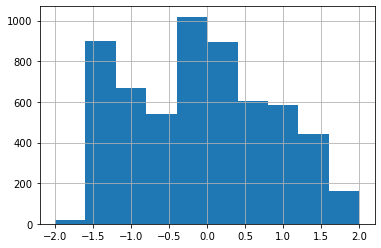

In [159]:
for i in data.index:

    # games that have been out longer can have more updates
    # -> '# updates per month since release'
    data.at[i, 'num_post'] /= (1 + data.at[i, 'release_date'])

    data.at[i, 'mean_time'] /= 30.0 # convert days->months

In [160]:
# log transform and normalize the data as before
data['num_pre'] = np.log(1 + 100*data['num_pre'])
data['num_post'] = np.log(1 + 200*data['num_post'])
data['mean_time'] = np.log(1 + 200*data['mean_time'])
data['len_description'] = np.log(1+data['len_description'])

data['num_pre'] = (data['num_pre'] - data['num_pre'].mean()) / data['num_pre'].std()
data['num_post'] = (data['num_post'] - data['num_post'].mean()) / data['num_post'].std()
data['mean_time'] = (data['mean_time'] - data['mean_time'].mean()) / data['mean_time'].std()


<h2> to do: generate some visualizations </h2>

I've tried some ways to visualize/split the data in features space but the results have been quite poor...

<b> Fitting with several different regressors, as in the previous analysis. </b>

We will evaluate the classifiers with f1 score: macro means unweighted average of the one-vs-rest f1 score whereas weighted means the classes are weighted by their proportions: postive ~ 0.73, mixed ~ 0.24 and negative ~0.03. The models are trained on a subset where the minority classes are oversampled.

For the 3-class classification problem, we can calculate the baseline macro f1 score for i) random guess and ii) weighted guess:

- If each class is guessed with $p=1/3$, then $f_{1, macro} \simeq 0.26$.
- For weighted guess, each class is guessed with $p_i = f_i$ where $f_i$ is the class frequency. In this case, $f_{1, macro} = 1/3 \simeq 0.33$.

In scikit-learn, f1 score offers multiclass options and seems more intuitive than AUC score when comparing against baseline classification strategies.

In [251]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix
from collections import Counter
from imblearn.over_sampling import SMOTE

X = data[['num_post','num_pre','mean_time'] + cat_vars].values
Y = data['sentiment'].values
print(Counter(list(Y)))
Y = Y.reshape(-1,1)

Counter({1.0: 4307, 0.0: 1505, -1.0: 215})


In [244]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.4)
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train.ravel())

dtc = DecisionTreeClassifier(max_depth=10)
dtc.fit(x_resampled, y_resampled)

y_pred = dtc.predict(x_test)
print(confusion_matrix(y_pred, y_test))
print('f1 macro', f1_score(y_pred, y_test.ravel(), average='macro'))
print('f1 weighted', f1_score(y_pred, y_test.ravel(), average='weighted'))

[[ 22 141 370]
 [ 32 194 529]
 [ 32 267 824]]
f1 macro 0.3120218508744614
f1 weighted 0.374965850663895


In [245]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.4)
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train.ravel())

rfc = RandomForestClassifier(n_estimators=15, max_depth=10, bootstrap=True)
rfc.fit(x_resampled, y_resampled)

y_pred = dtc.predict(x_test)
print(confusion_matrix(y_pred, y_test))
print('f1 macro', f1_score(y_pred, y_test.ravel(), average='macro'))
print('f1 weighted', f1_score(y_pred, y_test.ravel(), average='weighted'))

[[ 50 104 339]
 [ 21 295 424]
 [ 15 203 960]]
f1 macro 0.4247315470447888
f1 weighted 0.4936252685017247


In [246]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, stratify=Y, test_size = 0.4)
x_resampled, y_resampled = SMOTE().fit_resample(x_train, y_train.ravel())

log_reg = LogisticRegression(penalty='l2', C=100.0, solver='lbfgs',multi_class='ovr')
log_reg.fit(x_resampled, y_resampled)

y_pred = log_reg.predict(x_test)
print(confusion_matrix(y_pred, y_test))
print('f1 macro', f1_score(y_pred, y_test.ravel(), average='macro'))
print('f1 weighted', f1_score(y_pred, y_test.ravel(), average='weighted'))

[[  46  260  533]
 [  12   56  170]
 [  28  286 1020]]
f1 macro 0.30003789854624
f1 weighted 0.4169995455065479


In [247]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

skf = StratifiedKFold(n_splits=10)

def get_mean_f1(skf, X, Y, model):

    indices = skf.split(X, Y)

    f1_scores = []

    for train_indices, test_indices in indices:
        
        xr_train, xr_test = X[train_indices], X[test_indices]
        yr_train, yr_test = Y[train_indices], Y[test_indices]
    
        xr_resampled, yr_resampled = SMOTE().fit_resample(xr_train, yr_train.ravel())
        model.fit(xr_resampled, yr_resampled)
        yr_pred = model.predict(xr_test)
    
        f1_scores.append(f1_score(yr_pred, yr_test, average='macro'))

    return np.mean(f1_scores), np.std(f1_scores)


Compare the models on their scores using 10-fold CV:

In [252]:
print(get_mean_f1(skf, X, Y, dtc))
print(get_mean_f1(skf, X, Y, rfc))
print(get_mean_f1(skf, X, Y, log_reg))

(0.3590218011684674, 0.03246725827227365)
(0.3804666332418735, 0.020702495887429503)
(0.3443918449484222, 0.03435557696548091)


<b> In the end, although not better by much than weighted guess, the random forest classifier outperforms others. Adding the categorial features also helps - it does split the feature space up in other directions which makes the classifier perform better than the weighted guess baseline.